In [1]:
# for calculation
import numpy as np
from osgeo import ogr
from osgeo import gdal
from skimage.graph import route_through_array
from rdp import rdp

ModuleNotFoundError: No module named 'osgeo'

In [17]:
# only for visualization
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

# Define datafiles and weights

In [18]:
RASTER = "rasters.tif"
SHAPEFILE_START_POINT = "rasters/Start.shp"
SHAPEFILE_DESTINATION_POINT = "rasters/Destination.shp"

#Therefore, random weights can be selected and assigned. The interval of the weights is 1 to 5
# we have 26 sample rasters merged into one with 26 bands
COSTS = 1 + 4 * np.random.random_sample((26,))

# Function 1

Function 1: Raster algebra to calculate cost surface. Raster data contain 2 values: on value of the cells and one value where no objects are located. The function has to work in a way that, independently from the number of the raster data located in a directory, it reads all of them and calculate the cost surface. Input and output of the functions and format of the data output are provided. The raster algebra algorithm is a weighted sum of all raster data where each raster is multiplied by one weight, whose value comes from another routine:
Cost surface raster = (ras_1*weight_1+ras_2* weight_2+ras_3*weight_3...)

In [19]:
# TODO: function name and arguments
def function1(raster_filename, costs_array):
    data_source_gdal = gdal.Open(raster_filename, gdal.GA_ReadOnly)
    # TODO: do you need some exeption here?
    if data_source_gdal is None:
        return
    raster = data_source_gdal.ReadAsArray()
    cost_surface = (raster.reshape((raster.shape[0],-1)) * costs_array.reshape((-1,1))).reshape(raster.shape).sum(axis=0)
    return cost_surface

cost_surface_array = function1(RASTER, COSTS)

# Function 3

Function 3: Routing optimal path. Identification of optimal route + straightening to reduce zig-zags. Input and output of the functions and format of the data output are provided. The type of algorithm for routing will be discussed in detail.

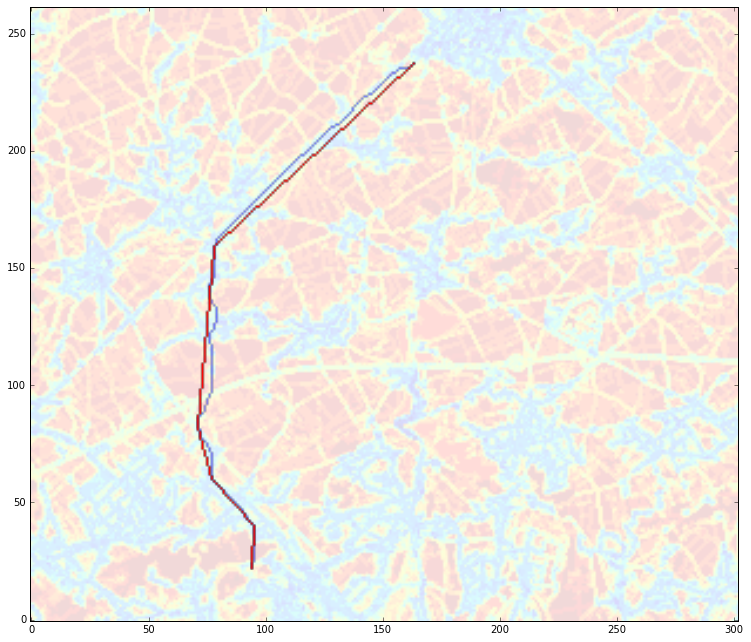

In [20]:
def function3(raster_filename,cost_surface_array,shapefile_start_name,shapefile_destination_name,epsilon=0):
    # get coordinates from shapefiles
    driverName = "ESRI Shapefile"
    drv = ogr.GetDriverByName( driverName )
    # shapefile driver is not available
    if drv is None:
        return
    driver = ogr.GetDriverByName('ESRI Shapefile')
    points = []
    for shapefile_name in [shapefile_start_name,shapefile_destination_name]:
        # open shapefile readonly
        dataSource = driver.Open(shapefile_name, 0)
        # file is not found or it can't be opened
        if dataSource is None:
            return
        layer = dataSource.GetLayer()
        featureCount = layer.GetFeatureCount()
        # should be only one point
        if featureCount != 1:
            return
        feature = layer.GetFeature(0)
        geometry = feature.GetGeometryRef()
        points.append( (geometry.GetX(), geometry.GetY()) )
    #print "points",points
    
    # convert geo coordinates from shapefiles to array indices
    data_source_gdal = gdal.Open(raster_filename, gdal.GA_ReadOnly)
    # TODO: do you need some exeption here?
    if data_source_gdal is None:
        return
    geotransform = data_source_gdal.GetGeoTransform()
    origin_x = geotransform[0]
    origin_y = geotransform[3] 
    pixel_width = geotransform[1] 
    pixel_height = geotransform[5]
    points_idx = []
    for point in points:
        x = int((point[0] - origin_x)/pixel_width)
        y = int((point[1] - origin_y)/pixel_height)
        points_idx.append( (y,x) )
    #print "points_idx",points_idx
    
    # create path
    indices, weight = route_through_array(cost_surface_array, points_idx[0], points_idx[1], geometric=True, fully_connected=True)
    indices = np.array(indices).T
    #print "indices", indices
    
    if epsilon == 0:
        path_array = np.nan * np.empty_like(cost_surface_array)
        path_array[indices[0], indices[1]] = 1
        return path_array
    else:
        indices_smoothed = rdp(indices.reshape((-1),order='F').reshape((-1,2)), epsilon).reshape((-1))
        #print "indices_smoothed", indices_smoothed
        x0 = None
        y0 = None
        indices_smoothed_x = []
        indices_smoothed_y = []
        for (x,y) in indices_smoothed.reshape((-1,2)):
            if not x0 is None:
                #print x0,y0,"->",x,y
                if abs(x-x0) >= abs(y-y0):
                    scale = 1.*(y-y0)/(x-x0)
                    for xx in range(x0,x+(1 if x>x0 else -1),1 if x>x0 else -1):
                        yy = y0 + int(round(scale*(xx-x0)))
                        #print "xx", xx, yy
                        indices_smoothed_x.append(xx)
                        indices_smoothed_y.append(yy)
                    assert(xx==x and yy==y)
                else:
                    scale = 1.*(x-x0)/(y-y0)
                    for yy in range(y0,y+(1 if y>y0 else -1),1 if y>y0 else -1):
                        xx = x0 + int(round(scale*(yy-y0)))
                        #print "yy", xx, yy
                        indices_smoothed_x.append(xx)
                        indices_smoothed_y.append(yy)
                    assert(xx==x and yy==y)
            x0 = x
            y0 = y
        # add last point
        #print "end point",x,y
        path_array_smoothed = np.nan * np.empty_like(cost_surface_array)
        #path_array_smoothed[indices_smoothed[::2],indices_smoothed[1::2]] = 1
        path_array_smoothed[indices_smoothed_x,indices_smoothed_y] = 1
        return path_array_smoothed

# Use "epsilon" for Ramer-Douglas-Peucker algorithm (straightening to reduce zig-zags)
# https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm
# epsilon = 0 by default
path_array = function3(RASTER, cost_surface_array, SHAPEFILE_START_POINT, SHAPEFILE_DESTINATION_POINT)
path_array_simplified = function3(RASTER, cost_surface_array, SHAPEFILE_START_POINT, SHAPEFILE_DESTINATION_POINT, epsilon=5)


plt.figure(figsize=(14,11))
plt.imshow(cost_surface_array, cmap='jet', alpha=0.15)
plt.imshow(path_array, cmap=colors.ListedColormap(['blue']), alpha=0.5)
plt.imshow(path_array_simplified, cmap=colors.ListedColormap(['red']))
plt.gca().invert_yaxis()